```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018, 2019  SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

This notebook implements the Kelvin waves test case, as reported 
under Case D in "Evaluation of Selected Finite-Difference and 
Finite-Volume Approaches to Rotational Shallow-Water Flow" 
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import datetime
import sys

from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [2]:
#%setup_logging --out galewsky.log
%cuda_context_handler gpu_ctx

In [3]:
image_folder = 'kelvin_images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(image_folder)
print ("Saving images to " + image_folder)

Saving images to kelvin_images_2023_03_08-11_22_07


# Kelvin waves!
Defining and analysing a test case for Kelvin waves.


In [4]:
def add_hovmuller(i, t, hovmuller_data, data):
    hovmuller_data['t'][i] = t
    for y, hovmuller in hovmuller_data['hovmuller']:
        hovmuller[i,:] = data[y,:]
    hovmuller_data['mass'][i] = data.sum()

def run_sim(sim, i, sub_dt, hovmuller_data, kill_left=-1):
    if (i>0):
        t = sim.step(sub_dt*sim.dt)
    else:
        t = 0.0

    if i == kill_left:
        eta1, u1, v1 = sim.download()
        eta1[:, :int(np.floor(sim.nx/2))] = 0
        u1[:, :int(np.floor(sim.nx/2))] = 0
        v1[:, :int(np.floor(sim.nx/2))] = 0
        eta_prev, u_prev, v_prev = sim.downloadPrevTimestep()
        eta_prev[:, :int(np.floor(sim.nx/2))] = 0
        u_prev[:, :int(np.floor(sim.nx/2))] = 0
        v_prev[:, :int(np.floor(sim.nx/2))] = 0

        sim.gpu_data.h0.upload(sim.gpu_stream, eta1)
        sim.gpu_data.hu0.upload(sim.gpu_stream, u1)
        sim.gpu_data.hv0.upload(sim.gpu_stream, v1)

        sim.gpu_data.h1.upload(sim.gpu_stream, eta_prev)
        sim.gpu_data.hu1.upload(sim.gpu_stream, u_prev)
        sim.gpu_data.hv1.upload(sim.gpu_stream, v_prev)


    eta1, u1, v1 = sim.download(interior_domain_only=True)

    if hovmuller_data is not None:
        add_hovmuller(i, t, hovmuller_data, eta1)
    return t
        
def sim_animation(sim, T, sub_dt=10, hovmuller_data=None, kill_left=-1):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    
    If hovmuller_data is provided, cross sections of the simulation is stored in the hovmuller_data arrays.
    hovmuller_data is expected to be of the format:
    hovmuller_data = {'t': 1D array of size T which will contain the simulation times,
            'hovmuller': [(y1, 2D array of size T times nx to store the cross sections),
                          (y2, 2D array of size T times nx to store the cross sections),
                           ...]}
    """
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(16, 16))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    eta_max = eta1.max()*0.5
    hu_max = max(v1.max(), u1.max())
    
    ax_eta = plt.subplot(3,1,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    plt.title('eta')
    #ax_eta.colorbar()
    
    ax_u = plt.subplot(3,1,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hu')
    #ax_u.colorbar()
    
    ax_v = plt.subplot(3,1,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-1, vmax=1, extent=domain_extent)
    plt.title('hv')
    #ax_v.colorbar()
    
    #Helper function which simulates and plots the solution
    def animate(i):
        
        t = run_sim(sim, i, sub_dt, hovmuller_data, kill_left)
        eta1, u1, v1 = sim.download(interior_domain_only=True)

        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)

        fig.sca(ax_u)
        sp_u.set_data(u1)

        fig.sca(ax_v)
        sp_v.set_data(v1)

        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

In [5]:
def eta_cell(r_i, r_j, rossby_radius, coriolis):
    f_func = 1.0 + np.tanh((-r_i + rossby_radius)/(rossby_radius/3))

    if coriolis:
        return np.exp(-r_j/rossby_radius)*f_func
    else:
        return f_func
    
def init_eta(eta, ghost_cells, rossby_radius, sim_args, coriolis=True):
    ny, nx = eta.shape
    x_0 = nx/2
    y_0 = ghost_cells[2]-0.5
    for j in range(0, ny):
        for i in range(0, nx):
            r_j = np.sqrt((j-y_0)**2)*sim_args["dy"]
            r_i = np.sqrt((i-x_0)**2)*sim_args["dx"]
            
            eta[j,i] = eta_cell(r_i, r_j, rossby_radius, coriolis)
            
            
def init_hu(hu, ghost_cells, rossby_radius, geoconst, sim_args, coriolis=True):
    if not coriolis:
        return
    ny, nx = hu.shape
    x_0 = nx/2
    y_0 = ghost_cells[2]-0.5
    for j in range(0, ny):
        for i in range(0, nx):
            r_j = np.sqrt((j-y_0)**2)*sim_args["dy"]
            r_i = np.sqrt((i-x_0)**2)*sim_args["dx"]
            
            eta_c = eta_cell(r_i, r_j, rossby_radius, coriolis)
            hu[j,i] = -geoconst*(-1.0/rossby_radius)*np.sign(j-y_0)*eta_c
            
            
    

In [6]:
gH = np.sqrt(10*100)
dx = 10000
print(dx/(gH*np.sqrt(2)))
      

223.60679774997897


In [7]:
def runPeriodicSims(sims=[1,1], animate=False, coriolis=True, cut_after=None, fine_grain_factor=1, 
                    theta=1.0, hu_push = 1.0, scale_wave=1.0, flux_delimiter=1.0):
    if animate:
        assert(sum(sims) == 1), "animation supported for one sim only"
    
    sim_args = {
        "gpu_ctx": gpu_ctx,
        "nx": int(500*fine_grain_factor), "ny": 200,
        "dx": 10000.0/fine_grain_factor, "dy": 10000.0,
        "dt": 50/fine_grain_factor,
        "g": 9.81,
        "f": 1.2e-4,
        "coriolis_beta": 0.0,
        "r": 0.0,
        "boundary_conditions": Common.BoundaryConditions(1,2,1,2)
    }
    fvm_args = {
        "theta": theta,
        "flux_delimiter": flux_delimiter
    }
    depth = 100
    rossby_radius = np.sqrt(sim_args["g"]*depth)/sim_args["f"]
    phase_speed = np.sqrt(sim_args['g']*depth)
    period = sim_args['dx']*sim_args['nx']/phase_speed
    geoconst = sim_args['g']*depth/sim_args['f']
    
    T = 101
    total_periodes = 10 # Number of simulated periods
    sub_dt = total_periodes*period/(sim_args['dt']*(T-1))

    print("rossby_radius: ", rossby_radius)
    print("phase_speed:   ", phase_speed)
    print("period:        ", period)
    print("timesteps per download: ", sub_dt)
    
    if not coriolis:
        sim_args["f"] = 0.0
    
    hovmuller_data = {'KP':  {'t': np.zeros(T),
                                'hovmuller': [(0,  np.zeros((T, sim_args["nx"]))), 
                                             (30, np.zeros((T, sim_args["nx"])))],
                                'mass': np.zeros(T)},
                      'CDKLM': {'t': np.zeros(T),
                                'hovmuller': [(0,  np.zeros((T, sim_args["nx"]))), 
                                              (30, np.zeros((T, sim_args["nx"])))],
                                'mass': np.zeros(T)},
                      'nx' : sim_args['nx'],
                      'dx' : sim_args['dx'],
                      'period' : period,
                      'theta' : fvm_args['theta'],
                      'flux_delimiter' : fvm_args['flux_delimiter'],
                      'hu_push' : hu_push,
                      'f' : sim_args['f'],
                      'dt' : sim_args['dt'],
                      'scale_wave': scale_wave
                     }

    
    for i, sim_name in zip(range(4), ["KP", "CDKLM"]):
        print("")
        if not sims[i]:
            print("skipping ", sim_name)
            continue
        print ("starting ", sim_name)
    
        ghosts = [2,2,2,2]

        dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                     sim_args["nx"] + ghosts[1]+ghosts[3])

        eta = np.zeros(dataShape, dtype=np.float32, order='C');
        hu, hv, H = None, None, None

        hu = np.zeros(dataShape, dtype=np.float32, order='C');
        hv = np.zeros(dataShape, dtype=np.float32, order='C');
        H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*depth

        init_eta(eta, ghosts, rossby_radius, sim_args, coriolis)
        init_hu( hu,  ghosts, rossby_radius, geoconst, sim_args, coriolis)
        
        if scale_wave != 0 or hu_push != 0:
            eta = eta*scale_wave
            hu = hu*hu_push*scale_wave
        
        #eta = eta*0.25
        #hu = hu*0.25
        
        init_args =  {
            "eta0" : eta,
            "hu0"  : hu,
            "hv0"  : hv,
            "H"    : H
        }
        
        sim = None
        if sim_name == "KP":
            sim = KP07.KP07(**sim_args, **init_args, **fvm_args)
        elif sim_name == "CDKLM":
            sim = CDKLM16.CDKLM16(**sim_args, **init_args, **fvm_args)
           
        kill_left = -1
        if not coriolis:
            kill_left = 3
            
        if cut_after is not None:
            T = cut_after
            
        if animate:
            return sim_animation(sim, T, sub_dt=sub_dt, hovmuller_data=None, kill_left=kill_left)

        else:
            for t in range(T):
                run_sim(sim, t, sub_dt, hovmuller_data[sim_name], kill_left=kill_left)
                print(".", end='')
    return hovmuller_data

In [8]:
# Check solution after one periode:
def plot_periodic_solution(all_data):
    
    sims = ['KP', 'CDKLM']
    for full in [False, True]:
        for sim in sims:
            hovmuller_data = all_data[sim]
            
            # Skip plotting if the simulator is not run
            if hovmuller_data['t'][1] == 0.0:
                continue

            fig = plt.figure(figsize=(10,3))
            nx = hovmuller_data['hovmuller'][0][1].shape[1]
            x_mid = int(nx/2)
            x_start = x_mid - int(nx/5)
            x_end   = x_mid + int(nx/5)
            if full:
                x_start = 0
                x_end = nx
            x_axis = np.array(range(x_start, x_end))*all_data['dx']/1000
            for hovmuller, ticks in zip(hovmuller_data['hovmuller'], ['-', '--']):
                #plt.cm.YlOrBr(norm(pval))
                #colormap=plt.cm.YlOrBr
                colormap=plt.cm.bone
                colorvals = [0.0, 0.3, 0.45, 0.6]
                label = [None, None, None, None]
                if ticks == '-':
                    label = ['Initial condition', '1 period', '5 periods', '10 periods' ]
                plt.plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                         ticks, color=colormap(colorvals[0]), label=label[0])
                plt.plot(x_axis, hovmuller[1][10, x_start:x_end], 
                         ticks, color=colormap(colorvals[1]), label=label[1])
                plt.plot(x_axis, hovmuller[1][50, x_start:x_end], 
                         ticks, color=colormap(colorvals[2]), label=label[2])
                plt.plot(x_axis, hovmuller[1][-1, x_start:x_end], 
                         ticks, color=colormap(colorvals[3]), label=label[3])

            
            if full:
                sim = sim + '_full'
            
            plt.title(sim)
            plt.ylim([-0.5*all_data['scale_wave'], 2.4*all_data['scale_wave']])
            plt.xlabel(u'$x$ (km)\n\n nx = ' + str(nx) +
                       ', theta = ' + str(all_data['theta']) + ', hu_push = ' + str(all_data['hu_push']) + 
                       ', f = ' + str(all_data['f']) + ', dt = ' + str(all_data['dt'])  + 
                       ', dx = ' + str(all_data['dx']) )
            plt.ylabel(u'$\eta$ (m)')
            plt.legend(loc=2)
            plt.grid()
            plt.tight_layout()
            plot_filename = image_folder + "/periodic_solution_nx" + str(all_data['nx']) + "_" + sim + ".pdf"
            if all_data['scale_wave'] < 0.9:
                plot_filename = plot_filename.replace('solution_', 'solution_smallwave_')
            plt.savefig(plot_filename)
            plt.savefig(plot_filename.replace('.pdf', '.png'))


def plot_total_mass(all_data):
    fig = plt.figure(figsize=(15,5))
    max_mass = 0.0
    for sim_name in ["KP", "CDKLM"]:
        plt.plot(all_data[sim_name]['t'] / all_data['period'], 
                 all_data[sim_name]['mass']-all_data[sim_name]['mass'][0], 
                 label=sim_name)
        max_mass = max(max_mass, np.max(all_data[sim_name]['mass']))
    plt.legend()
    plt.title('Total mass of eta')
    #plt.ylim([0, max_mass*1.1])
    plt.grid()
    print("total mass: ", max_mass)
    plot_filename = image_folder + "/preserved_mass_nx" + str(all_data['nx']) + ".pdf"
    plt.savefig(plot_filename)

In [9]:
def plot_parameter_solution(cdklm_data_parameters, param):

    plots = [plt.subplots(1,1,figsize=(10,3)) for i in range(4)]

    for cdklm in range(len(cdklm_data_parameters)):
        all_data = cdklm_data_parameters[cdklm]
        sims = ['KP', 'CDKLM']

        for sim in sims:
            hovmuller_data = all_data[sim]
            
            # Skip plotting if the simulator is not run
            if hovmuller_data['t'][1] == 0.0:
                continue
            nx = hovmuller_data['hovmuller'][0][1].shape[1]
            x_mid = int(nx/2)
            x_start = x_mid - int(nx/5)
            x_end   = x_mid + int(nx/5)
            x_axis = np.array(range(x_start, x_end))*all_data['dx']/1000
            for hovmuller, ticks in zip(hovmuller_data['hovmuller'], ['-', '--']):
                colormap=plt.cm.bone
                colorvals = np.linspace(0,0.75,len(cdklm_data_parameters))
                label = None
                if ticks == '-':
                    label = all_data[param]
                plots[0][1].plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                            ticks, color=colormap(colorvals[cdklm]), label=label)
                plots[1][1].plot(x_axis, hovmuller[1][10, x_start:x_end], 
                            ticks, color=colormap(colorvals[cdklm]), label=label)
                plots[2][1].plot(x_axis, hovmuller[1][50, x_start:x_end], 
                            ticks, color=colormap(colorvals[cdklm]), label=label)
                plots[3][1].plot(x_axis, hovmuller[1][-1, x_start:x_end], 
                            ticks, color=colormap(colorvals[cdklm]), label=label)
                
            for i in range(4):
                plots[i][1].legend()
        

In [10]:
def plot_sims(data):
    plots = [plt.subplots(1,1,figsize=(10,3)) for i in range(4)]

    sims = ['KP', 'CDKLM']

    for idx, sim in enumerate(sims):
        hovmuller_data = data[sim]
        
        # Skip plotting if the simulator is not run
        if hovmuller_data['t'][1] == 0.0:
            continue
        nx = hovmuller_data['hovmuller'][0][1].shape[1]
        x_mid = int(nx/2)
        x_start = x_mid - int(nx/5)
        x_end   = x_mid + int(nx/5)
        x_axis = np.array(range(x_start, x_end))*data['dx']/1000
        for hovmuller, ticks in zip(hovmuller_data['hovmuller'], ['-', '--']):
            colormap=plt.cm.bone
            colorvals = np.linspace(0,0.75,2)
            label = None
            if ticks == '-':
                label = sim
            plots[0][1].plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                        ticks, color=colormap(colorvals[idx]), label=label)
            
            plots[1][1].plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                        ticks, color="red", label="init")
            plots[1][1].plot(x_axis, hovmuller[1][10, x_start:x_end], 
                        ticks, color=colormap(colorvals[idx]), label=label)
            
            plots[2][1].plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                        ticks, color="red", label="init")
            plots[2][1].plot(x_axis, hovmuller[1][50, x_start:x_end], 
                        ticks, color=colormap(colorvals[idx]), label=label)
            
            plots[3][1].plot(x_axis, hovmuller[1][0 , x_start:x_end], 
                        ticks, color="red", label="init")
            plots[3][1].plot(x_axis, hovmuller[1][-1, x_start:x_end], 
                        ticks, color=colormap(colorvals[idx]), label=label)
            
        for i in range(4):
            legend_handles, legend_labels = plots[i][1].get_legend_handles_labels()
            if len(legend_labels) > 3:
                legend_handles, legend_labels = [legend_handles[0], legend_handles[1], legend_handles[4]], [legend_labels[0], legend_labels[1], legend_labels[4]]
            plots[i][1].legend(legend_handles, legend_labels)
    

# Initial conditions

We consider a domain with wall boundary conditions on the north and south boundaries, and periodic boundary conditions in east-west direction. We initialize a bump along the southern boundary, and with a momentum in x-direction according to the geostrophic balance.

In [11]:
#runPeriodicSims(sims=[1,0,0,0], fine_grain_factor=1, animate=True, cut_after=1)

# Kelvin waves with different grid resolutions

All figures show a cross section at $y=0.5 \Delta y$ with solid lines, and a cross section at $y = 30.5 \Delta y$ with dotted line.


From the meeting on Jan 9th 2019 we learned the following:

 - The numerics in the CTCS scheme is of such caracter that the phase speed of gravity waves are slowed down compared to linear advected waves. This results in the results that we see, where a shock is created *behind* the wave (and not in front of it). The explanation of this is found in LP's compendium, chapter 5.11 *Numerical dispersion* (or in his book). Figure 5.5 illustrates how the phase speeds of waves with different wave numbers are slowed down in the presence of different Courrant numbers (the factor for which we multiply the CFL condition to get $\Delta t$). Since the initial condition contains a wide specter of energy waves, some waves escape from the back of the slowed down wave, creating the oscillations that we observe.

 - In order to avoid these artifacts, we should be able to refine the grid resolution, and therefore 




### Domain with square cell sizes $(\Delta s, \Delta s)$ 

In [12]:
# %%time
# coriolis_data = runPeriodicSims(sims=[1,1], fine_grain_factor=1)

# plot_periodic_solution(coriolis_data)

In [13]:


#plot_total_mass(coriolis_data)

### Domain with cell sizes $(\Delta s/2, \Delta s)$ 

In [28]:
%%time
coriolis_data_2 = runPeriodicSims(sims=[1,1], fine_grain_factor=2, theta=1.0, flux_delimiter=1.0)

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  638.5508568141009

starting  KP
.....................................................................................................
starting  CDKLM
.....................................................................................................CPU times: user 12.8 s, sys: 31.1 ms, total: 12.8 s
Wall time: 12.8 s


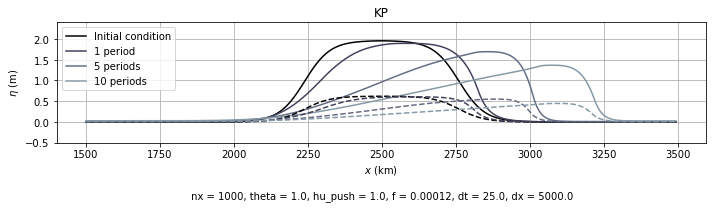

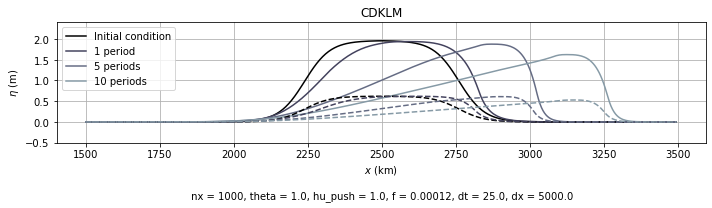

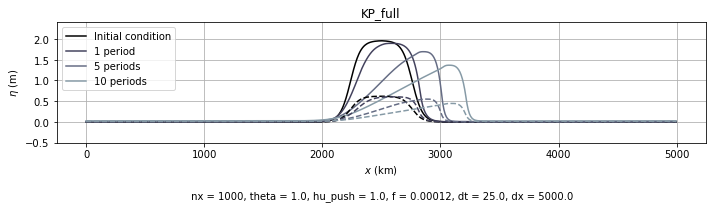

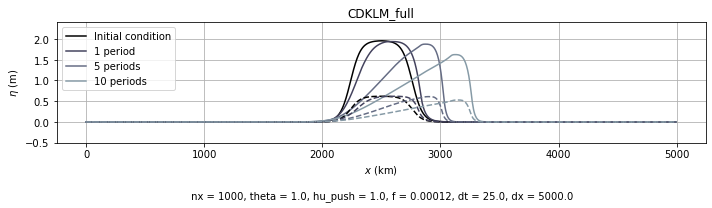

In [29]:
plot_periodic_solution(coriolis_data_2)

#plot_total_mass(coriolis_data_2)

### Domain with cell sizes $(\Delta s/2, \Delta s)$  with small bump

In [16]:
coriolis_data_small = runPeriodicSims(sims=[1,1], fine_grain_factor=2, scale_wave=0.025, theta=1.0, flux_delimiter=1.0)

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  638.5508568141009

starting  KP
.....................................................................................................
starting  CDKLM
.....................................................................................................CPU times: user 13.2 s, sys: 218 ms, total: 13.5 s
Wall time: 13.2 s


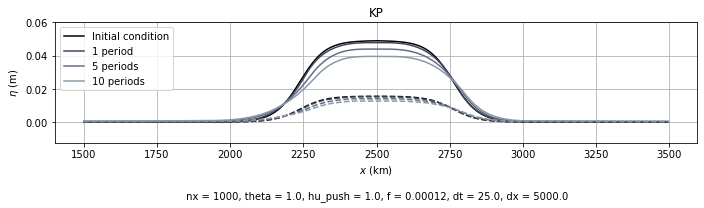

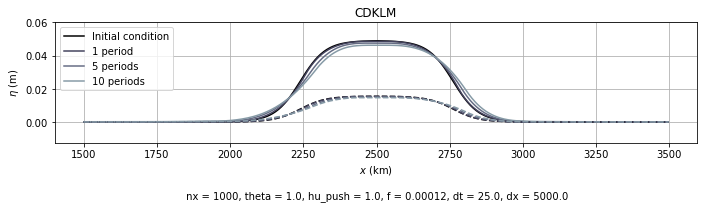

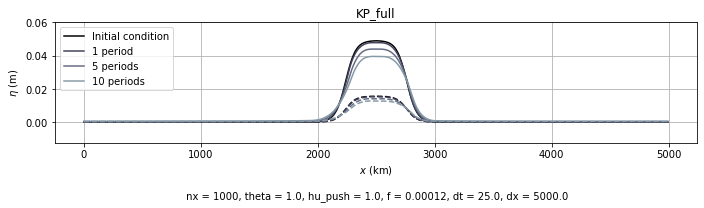

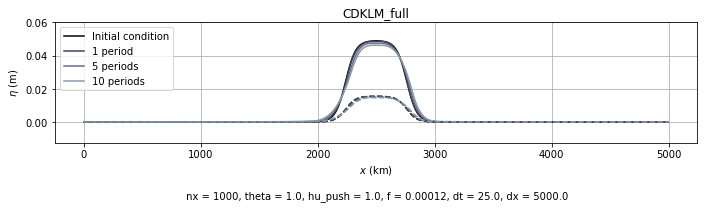

In [17]:
plot_periodic_solution(coriolis_data_small)

#plot_total_mass(coriolis_data_small)

## Testing different delimiters $\theta$ for the CDKLM scheme

The results shows that a delimiter closer to 2.0 gives a sharper shock, compared to using a delimiter with value closer to 1.0.

In [18]:
thetas = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

cdklm_data_thetas = []
for theta in thetas:
    cdklm_data_thetas.append( runPeriodicSims(sims=[0,1], theta=theta, flux_delimiter=1.0) )

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  K

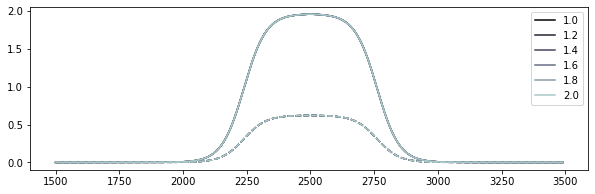

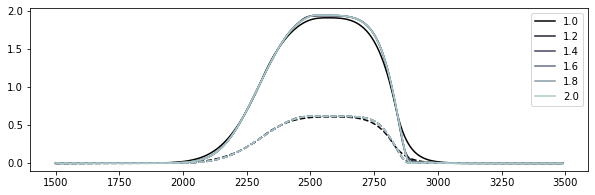

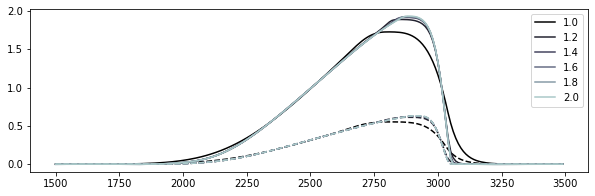

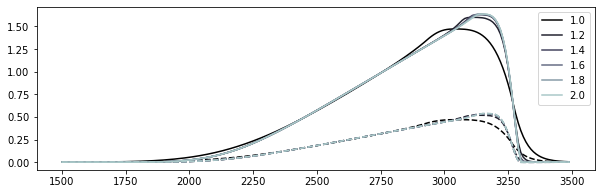

In [19]:
plot_parameter_solution(cdklm_data_thetas, "theta")

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  KP
.....................................................................................................
skipping  CDKLM
rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  KP
.....................................................................................................
skipping  CDKLM
rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  KP
.....................................................................................................
skipping  CDKLM
rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  K

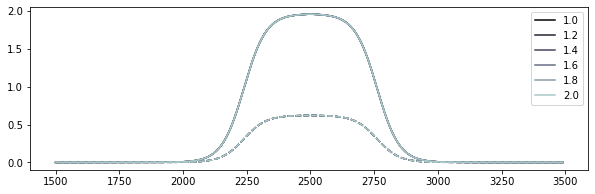

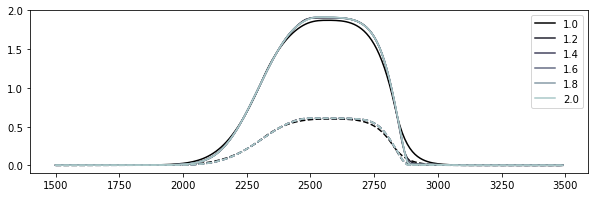

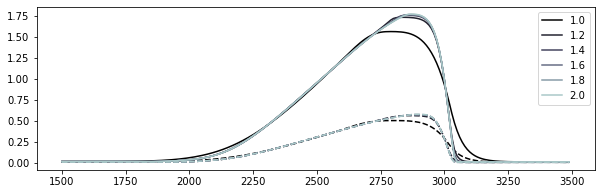

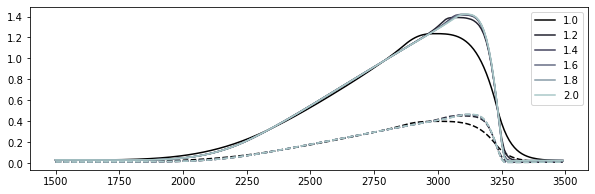

In [30]:
kp_data_thetas = []
for theta in thetas:
    kp_data_thetas.append( runPeriodicSims(sims=[1,0], theta=theta, flux_delimiter=1.0) )

plot_parameter_solution(kp_data_thetas, "theta")

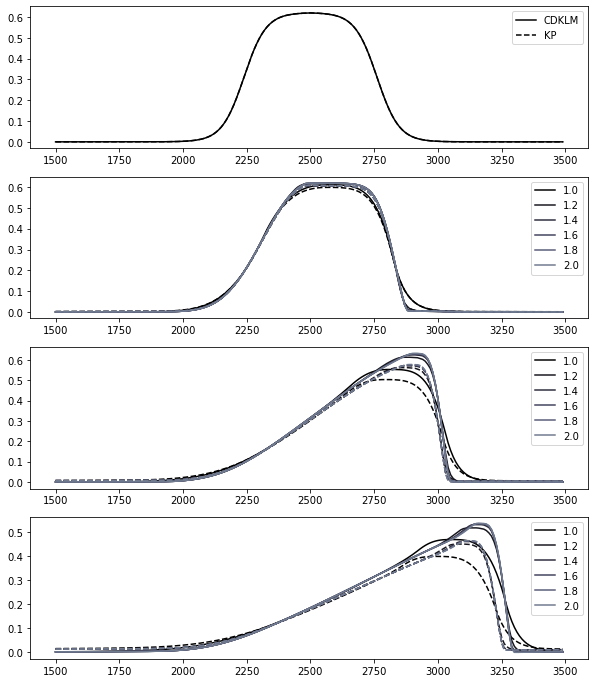

In [63]:
fig, axs = plt.subplots(4,1, figsize=(10,12))

kp_hovmuller_data = kp_data_thetas[0]["KP"]
cdklm_hovmuller_data = cdklm_data_thetas[0]["CDKLM"]
nx = kp_hovmuller_data['hovmuller'][0][1].shape[1]
x_mid = int(nx/2)
x_start = x_mid - int(nx/5)
x_end   = x_mid + int(nx/5)
x_axis = np.array(range(x_start, x_end))*kp_data_thetas[0]['dx']/1000


colormap=plt.cm.bone
colorvals = np.linspace(0,0.5,len(kp_data_thetas))

idxs = [0, 10, 50, -1]

axs[0].plot(x_axis, cdklm_data_thetas[0]["CDKLM"]['hovmuller'][1][1][idxs[0], x_start:x_end], "-", label="CDKLM", color=colormap(colorvals[0]))
axs[0].plot(x_axis, kp_data_thetas[0]["KP"]['hovmuller'][1][1][idxs[0], x_start:x_end], "--", label="KP", color=colormap(colorvals[0]))
axs[0].legend()


for p in range(1,4): 
    for theta in range(len(kp_data_thetas)):
        axs[p].plot(x_axis, cdklm_data_thetas[theta]["CDKLM"]['hovmuller'][1][1][idxs[p], x_start:x_end], "-", label=kp_data_thetas[theta]['theta'], color=colormap(colorvals[theta]))
        axs[p].plot(x_axis, kp_data_thetas[theta]["KP"]['hovmuller'][1][1][idxs[p], x_start:x_end], "--", color=colormap(colorvals[theta]))
        axs[p].legend()


## Testing different delimiters `flux_delimter` for the CDKLM scheme



In [20]:
flux_delimiters = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]

cdklm_data_delimiters = []
for flux_delimiter in flux_delimiters:
    cdklm_data_delimiters.append( runPeriodicSims(sims=[0,1], theta=1.5, flux_delimiter=flux_delimiter, scale_wave=0.025) )

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  KP

starting  CDKLM
.....................................................................................................rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

skipping  K

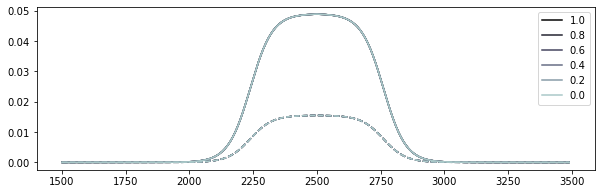

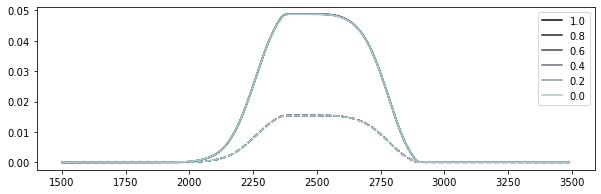

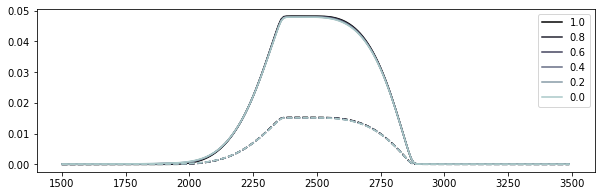

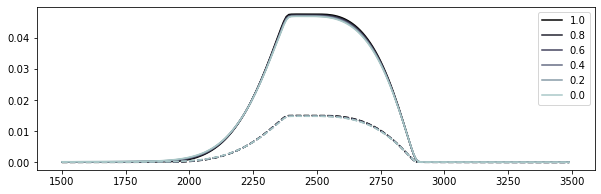

In [21]:
plot_parameter_solution(cdklm_data_delimiters,"flux_delimiter")

###  Compare KP and CDKLM with CU fluxes each

In [22]:
small_data = runPeriodicSims(sims=[1,1], theta=1.3, flux_delimiter=0.0, scale_wave=0.025)

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  KP
.....................................................................................................
starting  CDKLM
.....................................................................................................

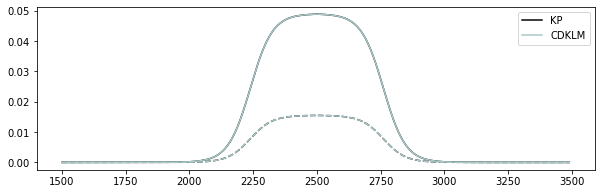

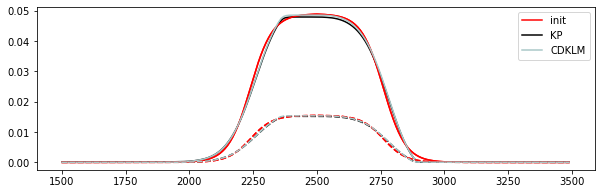

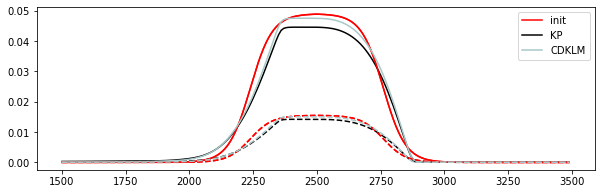

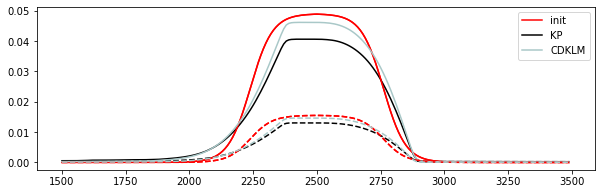

In [23]:
plot_sims(small_data)

In [24]:
big_data = runPeriodicSims(sims=[1,1], theta=1.5, flux_delimiter=0.0)

rossby_radius:  261007.66272276375
phase_speed:    31.32091952673165
period:         159637.71420352525
timesteps per download:  319.27542840705047

starting  KP
.....................................................................................................
starting  CDKLM
.....................................................................................................

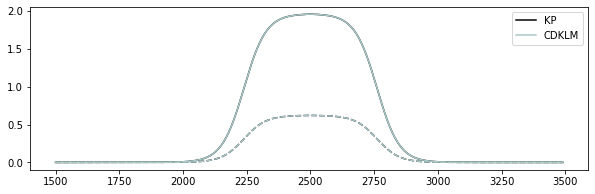

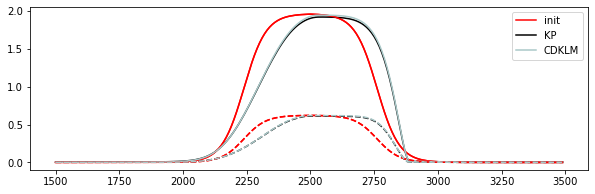

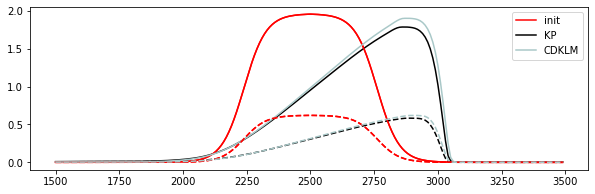

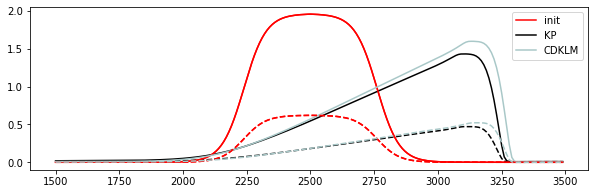

In [25]:
plot_sims(big_data)

Plot for paper

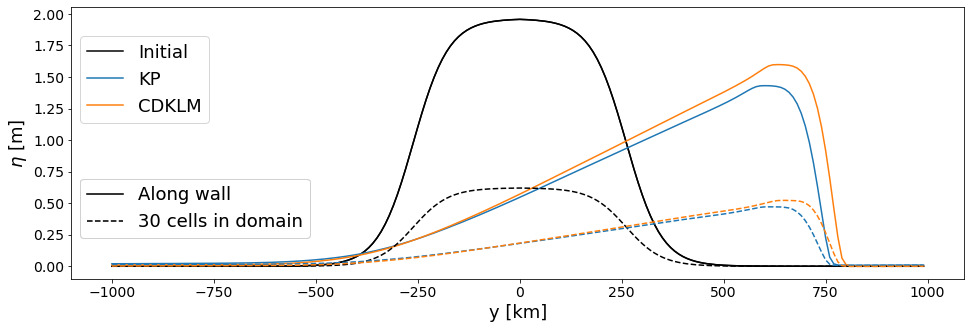

In [26]:
fig, axs = plt.subplots(1,1,figsize=(16,5))

nx = big_data["KP"]['hovmuller'][0][1].shape[1]
x_mid = int(nx/2)
x_start = x_mid - int(nx/5)
x_end   = x_mid + int(nx/5)
x_axis = np.array(range(x_start-x_mid, x_end-x_mid))*big_data['dx']/1000
axs.set_xlabel("y [km]", fontsize=18)
axs.set_ylabel("$\eta$ [m]", fontsize=18)

axs.tick_params(axis='both', which='major', labelsize=14)

solid, = axs.plot(x_axis, big_data["KP"]["hovmuller"][0][1][0 , x_start:x_end], "-", c="black", label="Initial")
solid2, = axs.plot(x_axis, big_data["KP"]["hovmuller"][0][1][0 , x_start:x_end], "-", c="black", label="Along wall")

kp,    = axs.plot(x_axis, big_data["KP"]["hovmuller"][0][1][-1 , x_start:x_end], "-", c="C0", label="KP")
cdklm, = axs.plot(x_axis, big_data["CDKLM"]["hovmuller"][0][1][-1 , x_start:x_end], "-", c="C1", label="CDKLM")


dashed, = axs.plot(x_axis, big_data["KP"]["hovmuller"][1][1][0 , x_start:x_end], "--", c="black", label="30 cells in domain")

axs.plot(x_axis, big_data["KP"]["hovmuller"][1][1][-1 , x_start:x_end], "--", c="C0")
axs.plot(x_axis, big_data["CDKLM"]["hovmuller"][1][1][-1 , x_start:x_end], "--", c="C1")

color_legend = plt.legend(handles=[solid, kp, cdklm],fontsize=18, loc=(0.01,0.575))
axs.add_artist(color_legend)

ls_legend = plt.legend(handles=[solid2, dashed],fontsize=18, loc=(0.01,0.15))
axs.add_artist(ls_legend)

os.makedirs("figs", exist_ok=True)
plt.savefig("figs/kelvin.pdf")

In [27]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_2136120/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

### Mass analysis

In [ ]:
plot_total_mass(big_data)

In [ ]:
# runPeriodicSims(sims=[1,0], animate=True, theta=1.5, flux_delimiter=0.0)

In [ ]:
# runPeriodicSims(sims=[0,1], animate=True, theta=1.5, flux_delimiter=0.0)

In [ ]:
animate=False
coriolis=True
cut_after=None
fine_grain_factor=2
theta=1.5
hu_push = 1.0
scale_wave=1.0
flux_delimiter=0.0

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": int(500*fine_grain_factor), "ny": 200,
    "dx": 10000.0/fine_grain_factor, "dy": 10000.0,
    "dt": 50/fine_grain_factor,
    "g": 9.81,
    "f": 1.2e-4,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "boundary_conditions": Common.BoundaryConditions(1,2,1,2)
}
fvm_args = {
    "theta": theta,
    "flux_delimiter": flux_delimiter
}
depth = 100
rossby_radius = np.sqrt(sim_args["g"]*depth)/sim_args["f"]
phase_speed = np.sqrt(sim_args['g']*depth)
period = sim_args['dx']*sim_args['nx']/phase_speed
geoconst = sim_args['g']*depth/sim_args['f']

T = 101
total_periodes = 10 # Number of simulated periods
sub_dt = total_periodes*period/(sim_args['dt']*(T-1))

print("rossby_radius: ", rossby_radius)
print("phase_speed:   ", phase_speed)
print("period:        ", period)
print("timesteps per download: ", sub_dt)

hovmuller_data = {'KP':  {'t': np.zeros(T),
                            'hovmuller': [(0,  np.zeros((T, sim_args["nx"]))), 
                                            (30, np.zeros((T, sim_args["nx"])))],
                            'mass': np.zeros(T)},
                    'CDKLM': {'t': np.zeros(T),
                            'hovmuller': [(0,  np.zeros((T, sim_args["nx"]))), 
                                            (30, np.zeros((T, sim_args["nx"])))],
                            'mass': np.zeros(T)},
                    'nx' : sim_args['nx'],
                    'dx' : sim_args['dx'],
                    'period' : period,
                    'theta' : fvm_args['theta'],
                    'flux_delimiter' : fvm_args['flux_delimiter'],
                    'hu_push' : hu_push,
                    'f' : sim_args['f'],
                    'dt' : sim_args['dt'],
                    'scale_wave': scale_wave
                    }


ghosts = [2,2,2,2]

dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                sim_args["nx"] + ghosts[1]+ghosts[3])

eta = np.zeros(dataShape, dtype=np.float32, order='C');
hu, hv, H = None, None, None

hu = np.zeros(dataShape, dtype=np.float32, order='C');
hv = np.zeros(dataShape, dtype=np.float32, order='C');
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*depth

init_eta(eta, ghosts, rossby_radius, sim_args, coriolis)
init_hu( hu,  ghosts, rossby_radius, geoconst, sim_args, coriolis)

if scale_wave != 0 or hu_push != 0:
    eta = eta*scale_wave
    hu = hu*hu_push*scale_wave

#eta = eta*0.25
#hu = hu*0.25

init_args =  {
    "eta0" : eta,
    "hu0"  : hu,
    "hv0"  : hv,
    "H"    : H
}

kp_sim = KP07.KP07(**sim_args, **init_args, **fvm_args)
cdklm_sim = CDKLM16.CDKLM16(**sim_args, **init_args, **fvm_args)

kp_sim.step(10*period)
cdklm_sim.step(10*period)

kp_eta, kp_hu, kp_hv = kp_sim.download(interior_domain_only=True)
cdklm_eta, cdklm_hu, cdklm_hv = cdklm_sim.download(interior_domain_only=True)

In [ ]:
"Mass =", np.sum(kp_eta), np.sum(cdklm_eta), "Mass diff = ", np.sum(cdklm_eta - kp_eta)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(50,10))

im = axs[0,0].imshow(kp_eta, origin="lower", vmin=0.0, vmax=1.5, cmap="Blues")
im = axs[0,1].imshow(cdklm_eta, origin="lower", vmin=0.0, vmax=1.5, cmap="Blues")

im = axs[1,0].imshow(cdklm_eta - kp_eta, origin="lower", vmin=-0.10, vmax=0.1, cmap="coolwarm")
im = axs[1,1].imshow(cdklm_eta < kp_eta, origin="lower", vmin=0.0, vmax=1.0, cmap="Reds")